<a href="https://colab.research.google.com/github/van-dang/VAWT-Cloud/blob/master/DFS_ALE_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
# !rm *.py *.xml *.txt *.zip *.pvd *.vtu *.geo *.msh
try:
    from google.colab import files
except:
    print("This is not google.colab")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
    !sudo apt-get update
    !sudo apt-get install -y gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


This is not google.colab


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


dolfin version: 2019.1.0


# Working on the mesh

--2019-07-10 13:39:14--  https://github.com/van-dang/VAWT-Cloud/raw/master/simple_2D_turbine.geo
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/van-dang/VAWT-Cloud/master/simple_2D_turbine.geo [following]
--2019-07-10 13:39:15--  https://raw.githubusercontent.com/van-dang/VAWT-Cloud/master/simple_2D_turbine.geo
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.84.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1034 (1.0K) [text/plain]
Saving to: ‘simple_2D_turbine.geo’

simple_2D_turbine.g 100%[===================>]   1.01K  --.-KB/s    in 0s      

2019-07-10 13:39:15 (23.6 MB/s) - ‘simple_2D_turbine.geo’ saved [1034/1034]

Info    : Running 'gmsh -2 simple_2D_turbine.geo -o simple_2D_

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


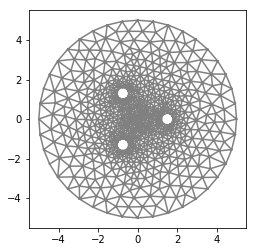

In [3]:
!rm simple_2D_turbine.geo
mesh_name='simple_2D_turbine'
is_geo_file_exist = os.path.isfile(mesh_name+'.geo')
if  is_geo_file_exist==False:
    !wget https://github.com/van-dang/VAWT-Cloud/raw/master/$mesh_name''.geo
!gmsh -2 $mesh_name''.geo -o $mesh_name''.msh
!dolfin-convert $mesh_name''.msh $mesh_name''.xml

# Solve the Navier-Stokes equations

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


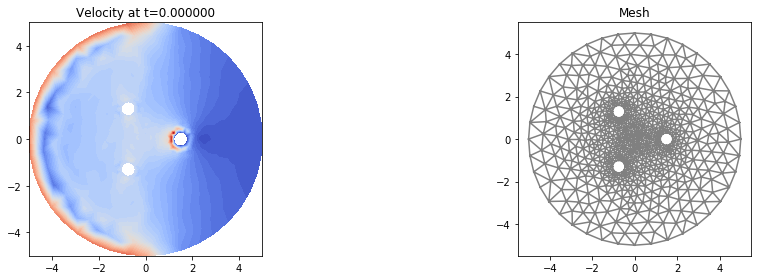

In [0]:
def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter % 5 == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Velocity at t=%f" % (t)) # Plot norm of velocity
    plt.subplot(1, 2, 2); plot(Q.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  return (pl, ax)

mesh = Mesh(mesh_name+'.xml')

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("1.0", "0."), element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > 0 ? 1. : 0.", element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < 0 ? 1. : 0.", element = Q.ufl_element())
nm = Expression("x[0]*x[0]+x[1]*x[1] < 16.0 ? 1. : 0.", element = Q.ufl_element())

stepcounter = 0; pl = None; ax = None

import math
pi = math.pi

class Beta(UserExpression):
    def set(self, rad_angle, k):
        self.rad_angle = rad_angle
        self.k = k
    def eval(self,values, x):
        values[0] = x[0]/self.k*(cos(self.rad_angle)-1)-x[1]/self.k*sin(self.rad_angle)
        values[1] = x[1]/self.k*(cos(self.rad_angle)-1)+x[0]/self.k*sin(self.rad_angle)
    def value_shape(self):
        return (2,)
      
beta = Beta()
      
k = 0.2; nu = 1e-6; d = 0.2*h # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
  if t<2.0:
      rad_angle = 0    
  else:
      rad_angle = -pi/180.;
  beta.set(rad_angle, k)
  mesh.rotate(rad_angle*180./pi);
  um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
  r = ((inner((u - u0)/k + grad(p) + grad(um)*(um-beta), v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
       gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
      d*(inner(grad(p) + grad(um)*(um), grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
  solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
  pl, ax = plot_compact(u, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
  t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep